### Load data

In [70]:
from sys import platform
if platform == 'linux' or platform == 'linux2':
    datapath = '/home/alin/MyLearning/Kaggle/Sberbank/data/'
else:
    datapath = 'C:/Users/alin/Documents/SelfStudy/MyLearning/Kaggle/Sberbank/data/'
print datapath

/home/alin/MyLearning/Kaggle/Sberbank/data/


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from sklearn import metrics
from sklearn.preprocessing import scale 

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [72]:

train_df = pd.read_csv(datapath + 'train.csv')
# change column nams to lower case
train_df.columns = train_df.columns.str.lower()
train_df.head()
original_cols = train_df.columns.tolist()

In [73]:
macro_df = pd.read_csv(datapath + 'macro.csv')
macro_df.columns = macro_df.columns.str.lower()
macro_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [74]:
%qtconsole

In [75]:
train_df = pd.merge(train_df, macro_df, on = 'timestamp')

### Exploration data analysis

In [76]:
train_df.shape

(30471, 391)

### process timestamp and build_year fields

In [77]:
 from datetime import datetime

In [78]:
train_df['year'] = map(lambda x: datetime.strptime(x, '%Y-%m-%d').year, train_df.timestamp)
#train_df['year'] = map(lambda x: int(x[0:4]), train_df.timestamp)
#train_df['month'] = map(lambda x: int(x[5:7]), train_df.timestamp)


In [79]:
train_df['month'] = map(lambda x: datetime.strptime(x, '%Y-%m-%d').month, train_df.timestamp)

Too many missing values of build_year, currently ignore it


In [80]:
#train_df.build_year = map(lambda x: x if x > 1850 and x < 2019 else np.nan, train_df.build_year)


#train_df['build_year1'] = train_df.build_year
#train_df.build_year1.fillna(train_df.build_year.mean(), inplace = True)
#train_df['age'] = train_df.year - train_df.build_year1

#train_df = train_df[(train_df.state.isnull()) | (train_df.state < 10)]

#del train_df['build_year1']

del train_df['timestamp']

### some  values are like '90,80" etc.

In [81]:
def myaoti(x):
    try:
        return float(str(x).replace(',', ''))
    except:
        return np.nan

In [82]:
#train_df['modern_education_share'] = train_df.modern_education_share.map(lambda x: float(str(x).replace(',','')))
train_df['modern_education_share'] = train_df.modern_education_share.map(myaoti)

train_df['old_education_build_share'] = train_df.old_education_build_share.map(myaoti)

train_df['child_on_acc_pre_school'] = train_df.child_on_acc_pre_school.map(myaoti)

In [83]:
def bi_convert(df, feature, pos = 'yes'):
    df[feature] = df[feature].map(lambda x: 1 if x == pos else 0)

In [84]:

bi_convert(train_df, 'thermal_power_plant_raion')
bi_convert(train_df, 'incineration_raion')
bi_convert(train_df, 'oil_chemistry_raion')
bi_convert(train_df, 'radiation_raion')
bi_convert(train_df, 'railroad_terminal_raion')
bi_convert(train_df, 'big_market_raion')
bi_convert(train_df, 'nuclear_reactor_raion')
bi_convert(train_df, 'detention_facility_raion')
bi_convert(train_df, 'water_1line')
bi_convert(train_df, 'big_road1_1line')
bi_convert(train_df, 'railroad_1line')
bi_convert(train_df, 'product_type', 'OwnerOccupier')
bi_convert(train_df, 'culture_objects_top_25')


In [85]:
def ecology_convert(x):
    eco ={'poor':-1, 'no data': 0, 'good': 1, 'satisfactory': 2, 'excellent': 3 }
    return eco[x]

In [86]:
train_df['ecology'] = train_df.ecology.map(ecology_convert)

### First find all columns with missing values, all numerical columns and all categorial columns

In [18]:
miss_cols = []
for col in train_df.columns:
    num_null = train_df[col].isnull().sum()
    if  num_null > 0:
        miss_cols.append((col, num_null*1.0 / train_df.shape[0]))

In [19]:
col_with_null = [c for (c,n) in miss_cols if n < 0.3]
exclude_col = [c for (c,n) in miss_cols if n >= 0.3]

remove those with >= 30% missing values

In [20]:
train_df_backup = train_df.copy()
train_df = train_df.drop(exclude_col, axis = 1)

In [89]:
num_df = train_df.select_dtypes(include = [np.number])
cat_df = train_df.select_dtypes(exclude = [np.number])

num_col = num_df.columns.tolist()
cat_col = cat_df.columns.tolist()

In [22]:
num_missing_col = list(set(col_with_null).intersection(set(num_col)))
cat_missing_col = list(set(col_with_null).intersection(set(cat_col)))
print len(num_missing_col), len(cat_missing_col)

77 0


Observation: all missing values are from numeric column.

In [23]:
a = train_df.copy()
a['price1'] = a.price_doc / 100000
a = a[a.life_sq < 7000]

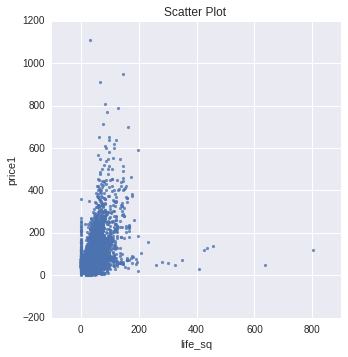

In [24]:
x = num_col[2]
y = 'price1'
sns.lmplot(x, y,
           data=a,
           fit_reg=False,
        
           
           scatter_kws={"marker": "D",
                        "s": 10})
plt.title('Scatter Plot ')
plt.xlabel(x)
plt.ylabel(y)

### For each column with missing value, we set the missing values to 0 and add a binary column recording the missing value locations

In [25]:
# each column (except the id one) of add_df corresonds to a column in train_df with missing value.
# The column is binary, 1 means missing in train_df, 0 otherwise.
#add_df = pd.DataFrame({'id': train_df.id})
#for col in num_missing_col:
#    add_df[col + '_missing'] = num_df[col].isnull().astype(int)
#num_df = num_df.fillna(0)
#del num_df['build_year']

In [26]:
num_df = num_df.fillna(num_df.mean())

### only one cat variable 'sub_area', combine low counts to "other" then one -hot encoding

In [27]:
sub1 = cat_df.sub_area.value_counts()
sub2 = sub1[sub1 < 20].index.tolist()

cat_df['sub_area'] = map(lambda x: 'Other' if x in sub2 else x, cat_df.sub_area)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [92]:
cat_one_hot = pd.get_dummies(cat_df.sub_area)

In [93]:
from random import shuffle
indices = num_df.index.tolist()
shuffle(indices)

In [94]:
train_ix = [indices[i] for i in range(21328)]
valid_ix = [indices[i] for i in range(21328, len(indices))]
num_train = num_df.ix[train_ix]
num_valid = num_df.ix[valid_ix]
cat_train = cat_one_hot.ix[train_ix]
cat_valid = cat_one_hot.ix[valid_ix]


In [95]:
y_train = np.log(num_train.price_doc.as_matrix()+1)
y_valid = np.log(num_valid.price_doc.as_matrix()+1)
num_train = num_train.drop(['id', 'price_doc'], axis = 1)
num_valid = num_valid.drop(['id', 'price_doc'], axis = 1)

### check out the predictive power of each variable
for numerical variable, use linear regression or tree(?)

In [44]:
def rmsle(lp, la):
    return np.sqrt(np.mean(np.square(lp - la)))

In [45]:
# a decision tree regresson on a simple numerical variable with performance on the validation set
def single_num(feature):
    X_train = num_train[feature].as_matrix().reshape(-1,1)
    X_valid = num_valid[feature].as_matrix().reshape(-1,1)
    tree = DecisionTreeRegressor(max_depth=5)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_valid)
    return rmsle(y_pred, y_valid)

In [46]:
def single_cat():

    X_train = cat_train.as_matrix()
    X_valid = cat_valid.as_matrix()
    tree = DecisionTreeRegressor(max_depth=5)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_valid)
    return rmsle(y_pred, y_valid)

In [37]:
#simple utility funciton to sort of visualize a tre
def get_code(tree, feature_names, tabdepth=0):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, tabdepth=0):
            if (threshold[node] != -2):
                    print '\t' * tabdepth,
                    print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node], tabdepth+1)
                    print '\t' * tabdepth,
                    print "} else {"
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node], tabdepth+1)
                    print '\t' * tabdepth,
                    print "}"
            else:
                    print '\t' * tabdepth,
                    print "return " + str(value[node])

    recurse(left, right, threshold, features, 0)

### order features by their single predicting power

In [106]:
power = []
num_col = num_train.columns.tolist()
for col in num_col:
    print col
    power.append((col, single_num(col)))
#power.append(('sub_area', single_cat()))


full_sq
life_sq


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [48]:
power = sorted(power, key = lambda x: x[1])

### now try some methods

### try with all numerical variables

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(num_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [79]:
y_pred = rf.predict(num_valid)

In [80]:
print rmsle(y_pred, y_valid)

0.471642319806


#top 10 numerical features

In [53]:
features = [f for (f,s) in power[0:50]]

num_train0 = num_train[features].as_matrix()

num_valid0 = num_valid[features].as_matrix()

rf = RandomForestRegressor(n_estimators=500)
rf.fit(num_train0, y_train)
y_pred = rf.predict(num_valid0)
print rmsle(y_pred, y_valid)

0.486221475389


### try xgboost

In [54]:
import xgboost as xgb

In [127]:
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

use_cols = original_cols + macro_cols

In [128]:
use_cols.remove('id')
use_cols.remove('timestamp')
use_cols.remove('sub_area')
use_cols.remove('price_doc')
use_cols = use_cols + ['year', 'month']     

In [129]:
num_train0 = num_train[use_cols]

In [130]:
num_valid0 = num_valid[use_cols]

In [131]:
xgtrain = xgb.DMatrix(num_train0.as_matrix(), y_train, feature_names=num_train0.columns.tolist())
xgvalid = xgb.DMatrix(num_valid0.as_matrix(), feature_names=num_valid0.columns.tolist())

In [132]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
num_round = 500
model = xgb.train(xgb_params, xgtrain, num_round)
# make prediction
y_pred1 = model.predict(xgvalid)
print rmsle(y_pred1, y_valid)



0.469523295601


In [ ]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [ ]:
features = [f for (f,s) in power[0:10]]
num_fea = list(set(features).difference(set(cat_col)))
cat_fea = list(set(features + ['product_type']).intersection(set(cat_col)))

In [115]:
train_num = train[num_fea].as_matrix()
train_cat = pd.get_dummies(train[cat_fea]).as_matrix()
valid_num = valid[num_fea].as_matrix()
valid_cat = pd.get_dummies(valid[cat_fea]).as_matrix()

In [116]:
X_train = np.concatenate((train_num, train_cat), axis = 1)
X_valid = np.concatenate((valid_num, valid_cat), axis = 1)

In [103]:
from sklearn.ensemble import RandomForestRegressor

In [117]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [118]:
y_pred = rf.predict(X_valid)

In [119]:
print rmsle(y_pred, y_valid)

0.478211748166


In [5]:
def single_cat(dSet, feature, target = 'risk'):
    """ exploring single categorical variable"""
    print "number of missing values =", dSet[feature].isnull().sum()
    
    #cross tabulation of feature v.s. target
    ctab = pd.crosstab(dSet[target], dSet[feature])
    rate = (ctab.iloc[1] / ctab.sum(axis = 0)).to_frame().T
    rate.index = range(2,3)
    ctab = pd.concat([ctab, rate])
    print ctab


In [6]:
def single_num(dSet, feature, target = 'risk'):
    """ exploring single numerical variable"""
    print "number of missing values =", dSet[feature].isnull().sum()
    print "summary of the whole set"
    print dSet[feature].describe()
    print "summary of subset with target = 0"
    print dSet[dSet[target] == 0][feature].describe()
    print "summary of subset with target = 1"
    print dSet[dSet[target] == 1][feature].describe()
    sns.plt.title('double density plot')
    sns.kdeplot(train[train[target]==0][feature], label = target + ' = 0')
    sns.kdeplot(train[train['risk']==1]['bb_activity_latest'], label = target + ' = 1')

#### aging

number of missing values = 0
summary of the whole set
count    7813.000000
mean       74.817612
std       103.293105
min         0.000000
25%         0.000000
50%        30.000000
75%        90.000000
max       360.000000
Name: aging, dtype: float64
summary of subset with target = 0
count    3489.000000
mean       35.821152
std        57.288883
min         0.000000
25%         0.000000
50%        30.000000
75%        60.000000
max       360.000000
Name: aging, dtype: float64
summary of subset with target = 1
count    4324.000000
mean      106.283534
std       120.061647
min         0.000000
25%        30.000000
50%        60.000000
75%       150.000000
max       360.000000
Name: aging, dtype: float64


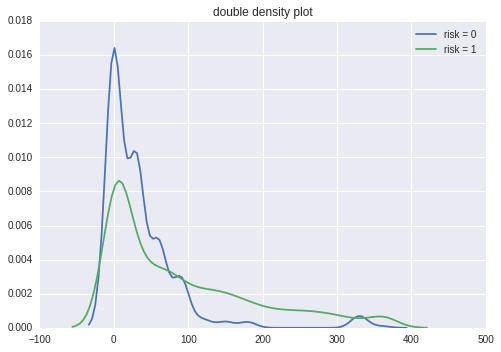

In [7]:
single_num(train, 'aging')

No missing value.
clearly longer aging --> higher risk

#### college

In [8]:
single_cat(train, 'college')

number of missing values = 0
college          ED           MG         PA           PH          PY
0        530.000000  1941.000000  59.000000   788.000000  171.000000
1        480.000000  2577.000000  94.000000  1042.000000  131.000000
2          0.475248     0.570385   0.614379     0.569399    0.433775


#### ba_age

number of missing values = 3
summary of the whole set
count    7810.000000
mean       37.957875
std         8.334605
min         0.000000
25%        32.000000
50%        37.000000
75%        43.000000
max       121.000000
Name: ba_age, dtype: float64
summary of subset with target = 0
count    3489.000000
mean       38.116652
std         8.552716
min         0.000000
25%        32.000000
50%        37.000000
75%        43.000000
max       121.000000
Name: ba_age, dtype: float64
summary of subset with target = 1
count    4321.000000
mean       37.829669
std         8.152974
min         1.000000
25%        32.000000
50%        37.000000
75%        43.000000
max        73.000000
Name: ba_age, dtype: float64


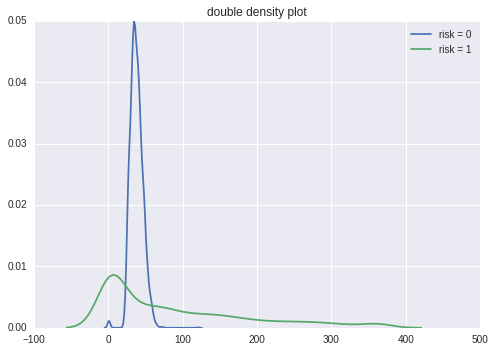

In [9]:
single_num(train, 'ba_age')

3 missing values, impute with mean

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


number of missing values = 0
summary of the whole set
count    7813.000000
mean       37.957875
std         8.333004
min         0.000000
25%        32.000000
50%        37.000000
75%        43.000000
max       121.000000
Name: ba_age, dtype: float64
summary of subset with target = 0
count    3489.000000
mean       38.116652
std         8.552716
min         0.000000
25%        32.000000
50%        37.000000
75%        43.000000
max       121.000000
Name: ba_age, dtype: float64
summary of subset with target = 1
count    4324.000000
mean       37.829758
std         8.150145
min         1.000000
25%        32.000000
50%        37.000000
75%        43.000000
max        73.000000
Name: ba_age, dtype: float64


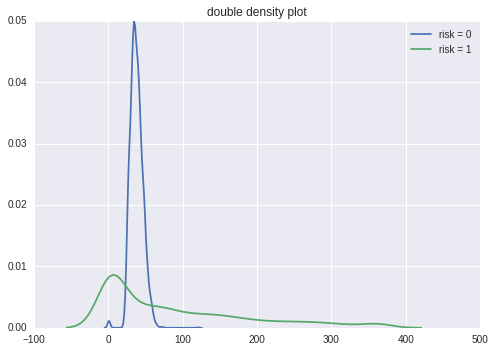

In [10]:
train.ba_age.fillna(train.ba_age.mean(), inplace = True)
single_num(train, 'ba_age')

#### gender

In [11]:
single_cat(train, 'gender')

number of missing values = 3
gender            F           M        N
0       1541.000000  1943.00000   5.0000
1       1448.000000  2862.00000  11.0000
2          0.484443     0.59563   0.6875


In [12]:
train.gender.fillna('N', inplace = True)
single_cat(train, 'gender')

number of missing values = 0
gender            F           M          N
0       1541.000000  1943.00000   5.000000
1       1448.000000  2862.00000  14.000000
2          0.484443     0.59563   0.736842


 #### cp_prior3mon_pay_total

number of missing values = 0
summary of the whole set
count    7813.000000
mean      307.369557
std       480.123325
min      -814.810000
25%         0.000000
50%         0.000000
75%       533.330000
max      6716.800000
Name: cp_prior3mon_pay_total, dtype: float64
summary of subset with target = 0
count    3489.000000
mean      536.322221
std       532.416251
min         0.000000
25%         0.000000
50%       410.040000
75%      1111.110000
max      2666.660000
Name: cp_prior3mon_pay_total, dtype: float64
summary of subset with target = 1
count    4324.000000
mean      122.629537
std       333.776852
min      -814.810000
25%         0.000000
50%         0.000000
75%         0.000000
max      6716.800000
Name: cp_prior3mon_pay_total, dtype: float64


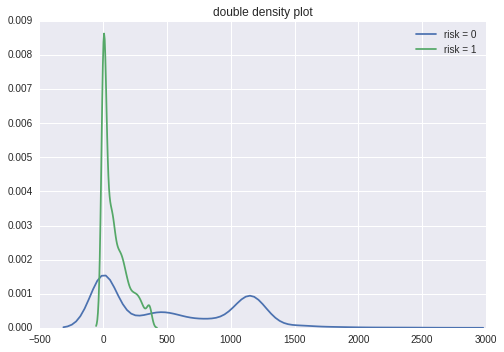

In [13]:
single_num(train, 'cp_prior3mon_pay_total')

There is an outlier -814.81, could be data error, another outlier 6717. Remove them before moving on.

number of missing values = 0
summary of the whole set
count    7811.000000
mean      306.692659
std       474.505758
min         0.000000
25%         0.000000
50%         0.000000
75%       533.330000
max      2666.660000
Name: cp_prior3mon_pay_total, dtype: float64
summary of subset with target = 0
count    3489.000000
mean      536.322221
std       532.416251
min         0.000000
25%         0.000000
50%       410.040000
75%      1111.110000
max      2666.660000
Name: cp_prior3mon_pay_total, dtype: float64
summary of subset with target = 1
count    4322.000000
mean      121.320715
std       318.104169
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2648.840000
Name: cp_prior3mon_pay_total, dtype: float64


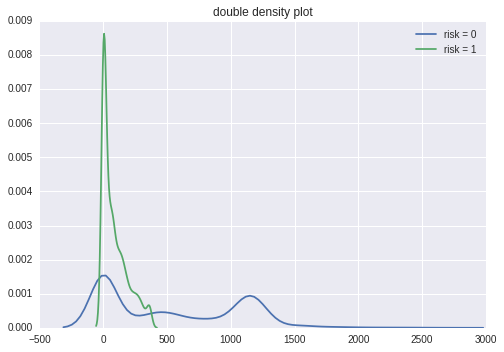

In [14]:
train = train[(train.cp_prior3mon_pay_total >= 0) &  (train.cp_prior3mon_pay_total < 2700)]
single_num(train, 'cp_prior3mon_pay_total')

#### nation_desc

In [15]:
# replace na with "Other'
train.nation_desc.isnull().any()
train.nation_desc.fillna('Other', inplace = True)
train.nation_desc.isnull().any()

False

In [16]:
nation_cnt = train.nation_desc.value_counts().to_dict()
train['nation_tr'] = map(lambda x: x if nation_cnt[x] > 50 else 'Other', train.nation_desc)

In [17]:
single_cat(train, 'nation_tr')

number of missing values = 0
nation_tr     ANGOLA  BOTSWANA      CANADA       GHANA    JAMAICA       KENYA  \
0          11.000000      34.0  144.000000  101.000000  41.000000   88.000000   
1          75.000000      51.0   45.000000  121.000000  32.000000  127.000000   
2           0.872093       0.6    0.238095    0.545045   0.438356    0.590698   

nation_tr    NAMIBIA     NIGERIA       Other     QATAR  SAUDI ARABIA  \
0          48.000000   942.00000  925.000000  81.00000    176.000000   
1          46.000000  1866.00000  922.000000  66.00000    151.000000   
2           0.489362     0.66453    0.499188   0.44898      0.461774   

nation_tr  SIERRA LEONE  SOUTH AFRICA  SOUTH SUDAN     UGANDA  \
0             59.000000    127.000000    28.000000  25.000000   
1             69.000000    173.000000    37.000000  40.000000   
2              0.539062      0.576667     0.569231   0.615385   

nation_tr  UNITED ARAB EMIRATES  UNITED KINGDOM  UNITED STATES     ZAMBIA  \
0                  

### important
crosstab of columns from the same df is not problem.
but crosstab of columns from different source can be a problem if their indices don't match.
So here we reset the train index for mkPredN()

In [18]:

train.index = range(train.shape[0])

### Explore one-variable model

#### categorical variable

In [53]:
def mkPredC(outCol, varCol, appCol):
    """outCol: the target column of the training data
       varCol: the variable column of the training data
       appCol: the variable column of the test/validate data
    this fuctions build a cross table of target v.s. a single categorical variable 
    using the training data and applied it to the appCol
       """
    pos = 1
    pPos = float(sum(outCol == pos)) /outCol.shape[0]
    vTab = pd.crosstab(outCol, varCol)
    pPosWv = (vTab.iloc[1] + 1.0e-3 * pPos) / (vTab.sum(axis = 0) + 1.0e-3)
    pred = pPosWv[appCol]
    pred.index = range(appCol.shape[0])
    return pred

#### numerical variable, converted into categorical variable

In [20]:
def cut(v, cuts):
    for i in range(cuts.shape[0] - 1):
        if v >= cuts[i] and v <= cuts[i+1]:
            return i
    return i

def mkPredN(outCol, varCol, appCol):
    pos = 1
    cuts = np.unique(np.percentile(varCol, range(0,110,10)))
    varC = pd.Series(map(lambda x: cut(x, cuts), varCol))
    appC = pd.Series(map(lambda x: cut(x, cuts), appCol))
    return mkPredC(outCol,varC,appC)
    #return cuts, varC, appC

#### function to calculate auc

In [21]:
def calcAUC(predcol, outcol):
    fpr, tpr, thresholds = metrics.roc_curve(outcol, predcol, pos_label=1)
    return metrics.auc(fpr, tpr)

#### use july and august as train, sep as val

In [22]:
numericalVars = ['future', 'aging', 'bb_activity_latest', 'cum_gpa', 'cum_credits',
                'ba_credits_passed_prior1yr', 'ba_age', 'cp_prior3mon_pay_total',
                'current_balance', 'module_cp', 'day_since_end', 'day_since_begin', 'day_to_begin']
catVars = ['program', 'degree', 'college', 'gender', 'in_module', 'in_future', 'in_dissertation', 'nation_tr']

In [23]:
train0 = train.ix[train.ind <= 8, numericalVars + catVars + ['risk']]
valid0 = train.ix[train.ind == 9, numericalVars + catVars + ['risk']]

#### scale numerical variables in train and valid, later for test

In [36]:
scaler = StandardScaler().fit(train0[numericalVars])
train0[numericalVars] = scaler.transform(train0[numericalVars])
valid0[numericalVars] = scaler.transform(valid0[numericalVars])


#dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])
#dfTest[['A','B','C']] = scale.fit_transform(dfTest[['A','B','C']].as_matrix())


#### check AUC for one variable models

In [44]:
train0.index = range(train0.shape[0])

In [ ]:
for v in numericalVars:
    train0['pred' + v] = mkPredN(train0.risk, train0[v], train0[v])
    valid0['pred' + v] = mkPredN(train0.risk, train0[v], valid0[v])
    aucTrain = calcAUC(train0['pred' + v], train0.risk)
    aucCal = calcAUC(valid0['pred' + v], valid0.risk)
    